In [1]:
import SimpleITK as sitk
import numpy as np
import csv
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
import pandas as pd

import keras as k
from keras.models import Sequential ,Model
from keras.layers import Conv2D, MaxPooling2D,AveragePooling3D,AveragePooling2D,MaxPooling3D,Conv3D
from keras.layers import Activation, Dropout, Flatten, Dense ,Input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing import image
from keras import applications

Using TensorFlow backend.
/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

def readCSV(filename):
    lines = []
    with open(filename, "rb") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray


In [13]:
def plotmymodel(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [2]:
cand_path = '../CSVFILES/candidates.csv'
outdir_nodule = 'output3d/nodule/'
outdir_non_nodule = 'output3d/non_nodule/'
cands = pd.read_csv(cand_path , header=0)

In [7]:
count1=0
for cand in tqdm(cands.values):
    path = glob('../subset*/'+cand[0]+".mhd")
    if len(path)>0:
        if cand[4]==1:
            numpyImage, numpyOrigin, numpySpacing = load_itk_image(path[0])
            worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
            voxelWidth = 64
            patch = numpyImage[int(voxelCoord[0]-voxelWidth/2):int(voxelCoord[0]+voxelWidth/2),int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2),int(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2)]
            patch = normalizePlanes(patch)

            desired= cand[4]
            
            if(desired==0):
                yy = [0,1]
            else:
                yy= [1,0]

            np.save(outdir_nodule+str(count1)+"1X.npy",patch)
            np.save(outdir_nodule+str(count1)+"1Y.npy",yy)
            
            count1 = count1 +1
                
print(count1)

 10%|▉         | 52370/551065 [00:09<01:33, 5329.29it/s]/home/ubuntu/.local/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 551065/551065 [01:53<00:00, 4869.56it/s]

574


In [8]:
#first 10,000 ---> 8932
count2=0

In [9]:
for cand in tqdm(cands.values[10000:20000]):
    path = glob('../subset*/'+cand[0]+".mhd")
    if len(path)>0:
        if cand[4]==0:
            numpyImage, numpyOrigin, numpySpacing = load_itk_image(path[0])
            worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
            voxelWidth = 64
            patch = numpyImage[int(voxelCoord[0]-voxelWidth/2):int(voxelCoord[0]+voxelWidth/2),int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2),int(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2)]
            patch = normalizePlanes(patch)

            desired= cand[4]
            
            if(desired==0):
                yy = [0,1]
            else:
                yy= [1,0]

            np.save(outdir_non_nodule+str(count2)+"0X.npy",patch)
            np.save(outdir_non_nodule+str(count2)+"0Y.npy",yy)
            
            count2 = count2 +1
                
print(count2)

  2%|▏         | 172/10000 [00:09<09:30, 17.22it/s]/home/ubuntu/.local/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [07:03<00:00, 23.61it/s]

4867


In [4]:
xtrain , ytrain= [] ,[]
l1 = glob(outdir_nodule+"*X.npy")
l2= glob(outdir_non_nodule+"*X.npy")
ll = l1[:500] + l2[:500]
shuffle(ll)
for x in ll:
    y = x[:-5] +"Y" + x[-4:]
    xx= np.load(x)
    yy = np.load(y)
    if xx.shape == (64,64,64):
        xx = np.expand_dims(xx,axis=3)
        xtrain.append(xx)
        ytrain.append(yy)

xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

xtrain.shape , ytrain.shape

((904, 64, 64, 64, 1), (904, 2))

In [158]:
unique, counts = np.unique(np.argmax(ytrain,axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 466, 1: 1330}

In [5]:
#Lnet
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=[64,64,64]))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

In [6]:
model.compile(loss=k.losses.categorical_crossentropy,
              optimizer=k.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])
model_checkpoint = ModelCheckpoint('todel/weights3d_lnet.hdf5', monitor='loss', save_best_only=True)

In [7]:
#model.load_weights('weights3d_lnet.hdf5')
histroylenet= model.fit(xtrain, ytrain,
          batch_size=1000,
          epochs=30,
          verbose=1,
          validation_split=0.1,
          callbacks=[model_checkpoint])

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (904, 64, 64, 64, 1)

In [93]:
model.save_weights('weights3d_new.hdf5')

In [19]:
from sklearn.metrics import confusion_matrix

In [91]:
predicted = model.predict(xtrain[:])
pre = np.argmax(predicted,axis=1)
tru = np.argmax(ytrain[:],axis=1)
confusion_matrix(tru, pre)

array([[ 710,  125],
       [  28, 8316]])

In [92]:
del xtrain
del ytrain

In [30]:
#Vanilla3d
def makevanilla():
    x    = Input(shape=(64,64,64,1))
    conv0= Conv3D(32,kernel_size=(3,3,3),padding="same",activation='relu')(x)
    conv0= Dropout(0.2)(conv0)
    avg1 = AveragePooling3D(pool_size=(2,1,1))(conv0)
    conv1= Conv3D(32,kernel_size=(3,3,3),padding="same",activation='relu')(avg1)
    conv1= Dropout(0.2)(conv1)
    max1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2= Conv3D(64,kernel_size=(3,3,3),padding="same",activation='relu')(max1)
    conv2= Dropout(0.2)(conv2)
    max2 = MaxPooling3D(pool_size=(2,2,2))(conv2)
    conv3= Conv3D(128,kernel_size=(3,3,3),padding="same",activation='relu')(max2)
    conv3= Dropout(0.2)(conv3)
    max3 = MaxPooling3D(pool_size=(2,2,2))(conv3)
    conv4= Conv3D(256,kernel_size=(3,3,3),padding="same",activation='relu')(max3)
    conv4= Dropout(0.2)(conv4)
    max4 = MaxPooling3D(pool_size=(2,2,2))(conv4)
    conv5= Conv3D(256,kernel_size=(3,3,3),padding="same",activation='relu')(max4)
    conv5= Dropout(0.2)(conv5)
    max5 = MaxPooling3D(pool_size=(2,2,2))(conv5)
    conv6= Conv3D(512,kernel_size=(3,3,3),padding="same",activation='relu')(max5)

    flat = Flatten()(conv6)
    flat= Dropout(0.2)(flat)
    dense= Dense(2,activation="softmax")(flat)

    vanillamodel = Model(inputs=x, outputs=dense)
    
    vanillamodel.compile(loss=k.losses.categorical_crossentropy,
              optimizer=k.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

    return vanillamodel

In [31]:
vanilla3d = makevanilla()
vanilla3d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 64, 1)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 64, 64, 64, 32)    896       
_________________________________________________________________
dropout_26 (Dropout)         (None, 64, 64, 64, 32)    0         
_________________________________________________________________
average_pooling3d_4 (Average (None, 32, 64, 64, 32)    0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 32, 64, 64, 32)    27680     
_________________________________________________________________
dropout_27 (Dropout)         (None, 32, 64, 64, 32)    0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 16, 32, 32, 32)    0         
__________

In [32]:
model_checkpoint = ModelCheckpoint('todel/weights3d_vanila.hdf5', monitor='loss', save_best_only=True)

In [33]:
historyVanilla= vanilla3d.fit(xtrain, ytrain,
          batch_size=20,
          epochs=20,
          verbose=1,
          validation_split=0.1,
          callbacks=[model_checkpoint])

Train on 813 samples, validate on 91 samples
Epoch 1/20
813/813 [==============================] - 37s 46ms/step - loss: 0.6856 - acc: 0.5621 - val_loss: 0.6815 - val_acc: 0.6813
Epoch 2/20
813/813 [==============================] - 37s 45ms/step - loss: 0.6668 - acc: 0.6113 - val_loss: 0.6866 - val_acc: 0.6703
Epoch 3/20
813/813 [==============================] - 37s 45ms/step - loss: 0.6256 - acc: 0.6593 - val_loss: 0.6190 - val_acc: 0.7473
Epoch 4/20
813/813 [==============================] - 37s 45ms/step - loss: 0.5348 - acc: 0.7343 - val_loss: 0.5986 - val_acc: 0.7692
Epoch 5/20
813/813 [==============================] - 37s 45ms/step - loss: 0.4937 - acc: 0.7724 - val_loss: 0.5345 - val_acc: 0.8242
Epoch 6/20
813/813 [==============================] - 37s 45ms/step - loss: 0.4864 - acc: 0.7688 - val_loss: 0.6046 - val_acc: 0.7253
Epoch 7/20
813/813 [==============================] - 37s 45ms/step - loss: 0.4548 - acc: 0.7897 - val_loss: 0.4952 - val_acc: 0.8462
Epoch 8/20
813/81

In [34]:
from sklearn.metrics import confusion_matrix
predicted = vanilla3d.predict(xtrain[:])
pre = np.argmax(predicted,axis=1)
tru = np.argmax(ytrain[:],axis=1)
confusion_matrix(tru, pre)

array([[461,   5],
       [ 11, 427]])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


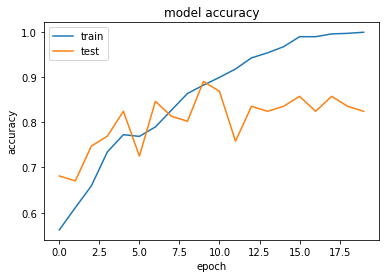

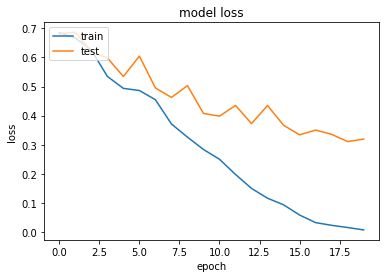

In [35]:
plotmymodel(historyVanilla)

In [36]:
def inceptionlayer(prev):
    tower_1 = Conv3D(64, (1,1,1), padding='same', activation='relu')(prev)
    tower_1 = Conv3D(64, (3,3,3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv3D(64, (1,1,1), padding='same', activation='relu')(prev)
    tower_2 = Conv3D(64, (5,5,5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling3D((3,3,3), strides=(1,1,1), padding='same')(prev)
    tower_3 = Conv3D(64, (1,1,1), padding='same', activation='relu')(tower_3)
    output = k.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [55]:
#GOOGLENET
def makegooglenet():
    x    = Input(shape=(64,64,64,1))
    conv1= Conv3D(32,kernel_size=(7,7,7),activation='relu')(x)
    conv1= Dropout(0.3)(conv1)
    max1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2= Conv3D(32,kernel_size=(3,3,3),activation='relu')(max1)
    conv2= Dropout(0.3)(conv2)
    max2 = MaxPooling3D(pool_size=(2,2,2))(conv2)
    incp1= inceptionlayer(max2)
    incp1= Dropout(0.3)(incp1)
    incp2= inceptionlayer(incp1)
    incp2= Dropout(0.3)(incp2)
    max3 = MaxPooling3D(pool_size=(2,2,2))(incp2)
    incp3= inceptionlayer(max3)
    incp3= Dropout(0.3)(incp3)
    incp4= inceptionlayer(incp3)
    incp4= Dropout(0.3)(incp4)
    max4 = MaxPooling3D(pool_size=(2,2,2))(incp4)
    incp5= inceptionlayer(max4)
    incp5= Dropout(0.3)(incp5)
    incp6= inceptionlayer(incp5)
    incp6= Dropout(0.3)(incp6)
    avg1= AveragePooling3D(pool_size=(2,2,2))(incp4)

    flat = Flatten()(avg1)
    flat= Dropout(0.3)(flat)
    dense= Dense(2,activation="softmax")(flat)

    googlenet = Model(inputs=x, outputs=dense)
    
    googlenet.compile(loss=k.losses.categorical_crossentropy,
              optimizer=k.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
    
    return googlenet
    
   
   

In [56]:
googlenet = makegooglenet()
googlenet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 64, 64, 64, 1 0                                            
__________________________________________________________________________________________________
conv3d_125 (Conv3D)             (None, 58, 58, 58, 3 11008       input_8[0][0]                    
__________________________________________________________________________________________________
dropout_60 (Dropout)            (None, 58, 58, 58, 3 0           conv3d_125[0][0]                 
__________________________________________________________________________________________________
max_pooling3d_51 (MaxPooling3D) (None, 29, 29, 29, 3 0           dropout_60[0][0]                 
__________________________________________________________________________________________________
conv3d_126

In [57]:
model_checkpoint = ModelCheckpoint('todel/weights3d_googlenet.hdf5', monitor='loss', save_best_only=True)

In [ ]:
googlenet.load_weights('weights3d_googlenet.hdf5')

In [ ]:
historyGoogle= googlenet.fit(xtrain, ytrain,
          batch_size=20,
          epochs=20,
          verbose=1,
          validation_split=0.1,
          callbacks=[model_checkpoint])

Train on 813 samples, validate on 91 samples
Epoch 1/20
813/813 [==============================] - 44s 54ms/step - loss: 0.8699 - acc: 0.5055 - val_loss: 0.6936 - val_acc: 0.4505
Epoch 2/20
813/813 [==============================] - 42s 52ms/step - loss: 0.6901 - acc: 0.5597 - val_loss: 0.6969 - val_acc: 0.4505
Epoch 3/20
813/813 [==============================] - 42s 52ms/step - loss: 0.6806 - acc: 0.5683 - val_loss: 0.6909 - val_acc: 0.7692
Epoch 4/20
813/813 [==============================] - 42s 52ms/step - loss: 0.6615 - acc: 0.5953 - val_loss: 0.6567 - val_acc: 0.6703
Epoch 5/20
813/813 [==============================] - 42s 52ms/step - loss: 0.6061 - acc: 0.6679 - val_loss: 0.6161 - val_acc: 0.6593
Epoch 6/20
813/813 [==============================] - 42s 52ms/step - loss: 0.5755 - acc: 0.7171 - val_loss: 0.6586 - val_acc: 0.5934
Epoch 7/20
813/813 [==============================] - 42s 52ms/step - loss: 0.5280 - acc: 0.7491 - val_loss: 0.5696 - val_acc: 0.7802
Epoch 8/20
813/81

In [53]:
from sklearn.metrics import confusion_matrix
predicted = googlenet.predict(xtrain[:])
pre = np.argmax(predicted,axis=1)
tru = np.argmax(ytrain[:],axis=1)
confusion_matrix(tru, pre)

array([[315, 151],
       [  0, 438]])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


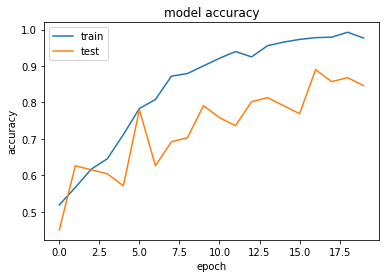

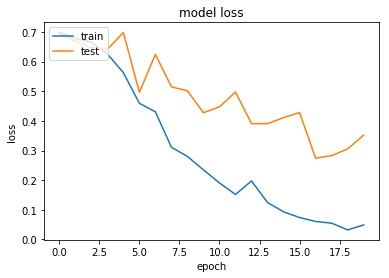

In [54]:
plotmymodel(historyGoogle)